In [2]:
import numpy as np
from scipy import stats
from tqdm import tqdm
from statsmodels.stats.power import tt_ind_solve_power, tt_solve_power
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Конверсия сайта

Эксперимент с конверсией с сайта. Есть старый дизайн и новый дизайн. Конверсия составляет 1%. Предположение, что при изменении дизайна конверсия увеличится до 1,3%. 

Провести стат тест. Определить минимально необходимый размер выборки и доверительный интервал.

## Частотный АВ-тест

### Статистическая значимость различий

In [32]:
# Конверсии в процентах для двух групп
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE = 1000

# Создаем массивы для групп, где 1 представляет конверсию, а 0 - неконверсию
data_control = np.random.binomial(1, conversion_rate_control, size=SIZE)
data_experiment = np.random.binomial(1, conversion_rate_experiment, size=SIZE)

# Применяем двухвыборочный t-тест для сравнения средних
t_statistic, p_value = stats.ttest_ind(data_control, data_experiment)

# Проверяем статистическую значимость на уровне 0.05
alpha = 0.05
if p_value < alpha:
    result = f"{bcolors.OKGREEN}Нулевая гипотеза отклонена, Есть статистически значимое различие{bcolors.ENDC}"
else:
    result = f"{bcolors.FAIL}Нулевая гипотеза не может быть отклонена, Нет статистически значимого различия{bcolors.ENDC}"

print(f"Результат A/B-теста: {result}")
print(f"p_value: {p_value:.4f}")
print(f'Учитывая, что H_0 верна, вероятность того, что мы получим наблюдаемый или \
еще более экстремальный исход, составляет не более {p_value:.4f} %.')

Результат A/B-теста: Нулевая гипотеза не может быть отклонена, Нет статистически значимого различия
p_value: 0.7956
Учитывая, что H_0 верна, вероятность того, что мы получим наблюдаемый или еще более экстремальный исход, составляет не более 0.7956 %.


## Проведем несколько сравнений

In [99]:
# Конверсии в процентах для двух групп
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE = 40000
plus = 0
minus = 0
for i in range(100):
    # Создаем массивы для групп, где 1 представляет конверсию, а 0 - неконверсию
    data_control = np.random.binomial(1, conversion_rate_control, size=SIZE)
    data_experiment = np.random.binomial(1, conversion_rate_experiment, size=SIZE)

    # Применяем двухвыборочный t-тест для сравнения средних
    t_statistic, p_value = stats.ttest_ind(data_control, data_experiment)

    # Проверяем статистическую значимость на уровне 0.05
    alpha = 0.05
    if p_value < alpha:
        plus += 1
        # result = f"{bcolors.OKGREEN}Нулевая гипотеза отклонена, Есть статистически значимое различие{bcolors.ENDC}"
    else:
        minus += 1
        # result = f"{bcolors.FAIL}Нулевая гипотеза не может быть отклонена, Нет статистически значимого различия{bcolors.ENDC}"

print(f'{bcolors.OKGREEN}Отклонений нулевой гипоезы\t{plus}{bcolors.ENDC}')
print(f'{bcolors.FAIL}Нулевая гипотеза не отклонена\t{minus}{bcolors.ENDC}')

Отклонений нулевой гипоезы	97
Нулевая гипотеза не отклонена	3


## Разберем по шагам

In [104]:
# Исходные данные
# Конверсии в процентах для двух групп
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE = 1000

# Создаем массивы для групп, где 1 представляет конверсию, а 0 - неконверсию
data_control = np.random.binomial(1, conversion_rate_control, size=SIZE)
data_experiment = np.random.binomial(1, conversion_rate_experiment, size=SIZE)

Для того, чтобы воспользоваться двухвыборочным t-тестом для сравнения средних нам необходимо убедиться, что дисперсии наших выборок равны.

Для этого можно использовать следующие методы:
- Бартлетта. Он чувствителен к нормальности распределения;
- Левена (Ливиня). Менее чувствителен к нормальности, самый популярный тест;
- Флигнера-Килина. Не чувствителен к отклонениям от нормальности и выбросам, подходит для ненормального распределения;

Будем использовать тест Левена

In [107]:
# Применение теста Левена
stat, p_value = stats.levene(data_control, data_experiment)

# Вывод результатов
print(f"Статистика Левена: {np.round(stat, 4)}")
print(f"p-значение: {np.round(p_value, 4)}")

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print(f"{bcolors.FAIL}Отвергаем нулевую гипотезу: дисперсии не равны.{bcolors.ENDC}")
else:
    print(f"{bcolors.OKGREEN}Не отвергаем нулевую гипотезу: дисперсии равны.{bcolors.ENDC}")

Статистика Левена: 0.224
p-значение: 0.636
Не отвергаем нулевую гипотезу: дисперсии равны.


Точность теста Левена

In [115]:
# Конверсии в процентах для двух групп
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE = 100

# Параметры для распределения выборочных средних
sample_size = SIZE
num_samples = SIZE

# Вычисление параметров нормального распределения выборочных средних
std_of_control_means = np.sqrt(conversion_rate_control*(1-conversion_rate_control)/sample_size)
std_of_experiment_means = np.sqrt(conversion_rate_experiment*(1-conversion_rate_experiment)/sample_size)

sample_control = stats.norm.rvs(loc=conversion_rate_control, scale=std_of_control_means, size=num_samples)
sample_experiment = stats.norm.rvs(loc=conversion_rate_experiment, scale=std_of_experiment_means, size=num_samples)

# Применение теста Левена
stat, p_value = stats.levene(sample_control, sample_experiment)

# Вывод результатов
print(f"Статистика Левена: {np.round(stat, 4)}")
print(f"p-значение: {np.round(p_value, 4)}")

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print(f"{bcolors.FAIL}Отвергаем нулевую гипотезу: дисперсии не равны.{bcolors.ENDC}")
else:
    print(f"{bcolors.OKGREEN}Не отвергаем нулевую гипотезу: дисперсии равны.{bcolors.ENDC}")

print(f'\nТочность теста:')
print(f'Дисперсия в эксперименте\t{std_of_experiment_means:1.4f}')
print(f'Дисперсия в контроле\t\t{std_of_control_means:1.4f}')
print(f'Разница в дисперсиях\t\t{np.abs(std_of_control_means - std_of_experiment_means)/std_of_experiment_means/100:1.4f}%')

Статистика Левена: 1.9674
p-значение: 0.1623
Не отвергаем нулевую гипотезу: дисперсии равны.

Точность теста:
Дисперсия в эксперименте	0.0113
Дисперсия в контроле		0.0099
Разница в дисперсиях		0.0012%


### Распределение выборочных средних

#### Сколько примеров нам нужно собрать

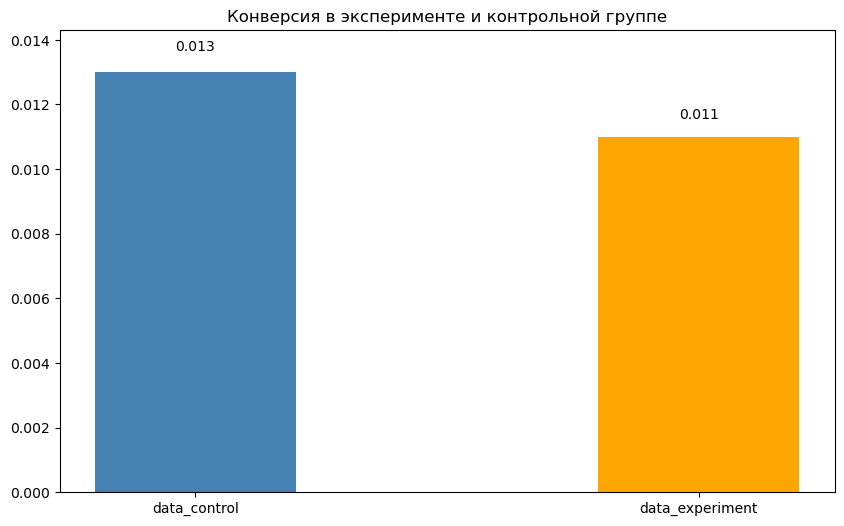

In [119]:
# Конверсии в процентах для двух групп
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE = 1000

# Создаем массивы для групп, где 1 представляет конверсию, а 0 - неконверсию
data_control = np.random.binomial(1, conversion_rate_control, size=SIZE).mean()
data_experiment = np.random.binomial(1, conversion_rate_experiment, size=SIZE).mean()
if data_control > data_experiment:
    colors = ['steelblue', 'orange']
else:
    colors = ['orange', 'steelblue']

plt.figure(figsize=(10, 6))
plt.bar(['data_control', 'data_experiment'], [data_control, data_experiment], color=colors, width=0.4)
plt.ylim([0, max([data_control, data_experiment])* 1.1])
plt.title('Конверсия в эксперименте и контрольной группе')
plt.text(0, data_control * 1.05, data_control, ha='center')
plt.text(1, data_experiment * 1.05, data_experiment, ha='center')
# plt.savefig('../Presentation/experiment.png')
plt.show()

In [130]:
# Сколько раз мы полчим те или иные резуьтаты
res = 0
num_experiments = 100
for i in range(num_experiments):
    # Конверсии в процентах для двух групп
    conversion_rate_control = 0.01  # Группа контроля
    conversion_rate_experiment = 0.013  # Группа эксперимента

    SIZE = 1000

    # Создаем массивы для групп, где 1 представляет конверсию, а 0 - неконверсию
    data_control = np.random.binomial(1, conversion_rate_control, size=SIZE).mean()
    data_experiment = np.random.binomial(1, conversion_rate_experiment, size=SIZE).mean()

    if data_control > data_experiment:
        res += 1

print(f'В {res} из {num_experiments} случаев контрольная группа лучше эксперимента. Мы не зафиксировали эффекта.')

В 24 из 100 случаев контрольная группа лучше эксперимента. Мы не зафиксировали эффекта.


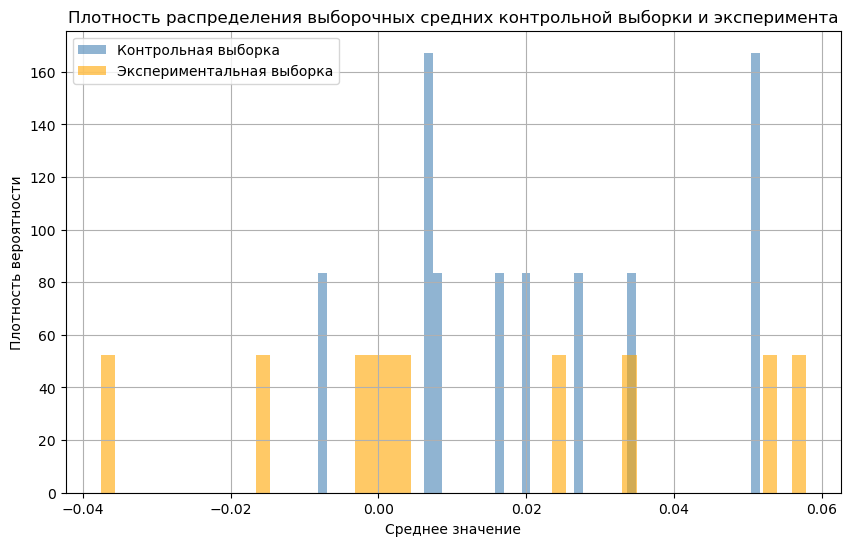

In [131]:
# Конверсии в процентах для двух групп
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE = 10

# Параметры для распределения выборочных средних
sample_size = SIZE
num_samples = SIZE

# Вычисление параметров нормального распределения выборочных средних
std_of_control_means = np.sqrt(conversion_rate_control*(1-conversion_rate_control)/sample_size)
std_of_experiment_means = np.sqrt(conversion_rate_experiment*(1-conversion_rate_experiment)/sample_size)

sample_control = stats.norm.rvs(loc=conversion_rate_control, scale=std_of_control_means, size=num_samples)
sample_experiment = stats.norm.rvs(loc=conversion_rate_experiment, scale=std_of_experiment_means, size=num_samples)

# Генерация значений для оси X
x = np.linspace(0, 0.03, num_samples)

# Вычисление плотности вероятности для нормального распределения
pdf_control = stats.norm.pdf(x, conversion_rate_control, std_of_control_means)
pdf_experiment = stats.norm.pdf(x, conversion_rate_experiment, std_of_experiment_means)

# Построение графика плотности распределения выборочных средних
plt.figure(figsize=(10, 6))
plt.hist(sample_control, bins=50, density=True, alpha=0.6, color='steelblue', label='Контрольная выборка')
plt.hist(sample_experiment, bins=50, density=True, alpha=0.6, color='orange', label='Экспериментальная выборка')
# plt.plot(x, pdf_control, color='steelblue')
# plt.plot(x, pdf_experiment, color='orange')
plt.title('Плотность распределения выборочных средних контрольной выборки и эксперимента')
plt.xlabel('Среднее значение')
plt.ylabel('Плотность вероятности')
# plt.axvline(x=conversion_rate_control, color='red', linestyle='--', label='Среднее значение контрольной выборки')
# plt.axvline(x=conversion_rate_experiment, color='green', linestyle='--', label='Среднее значение экспериментальной выборки')
plt.legend()
plt.grid(True)
plt.show()

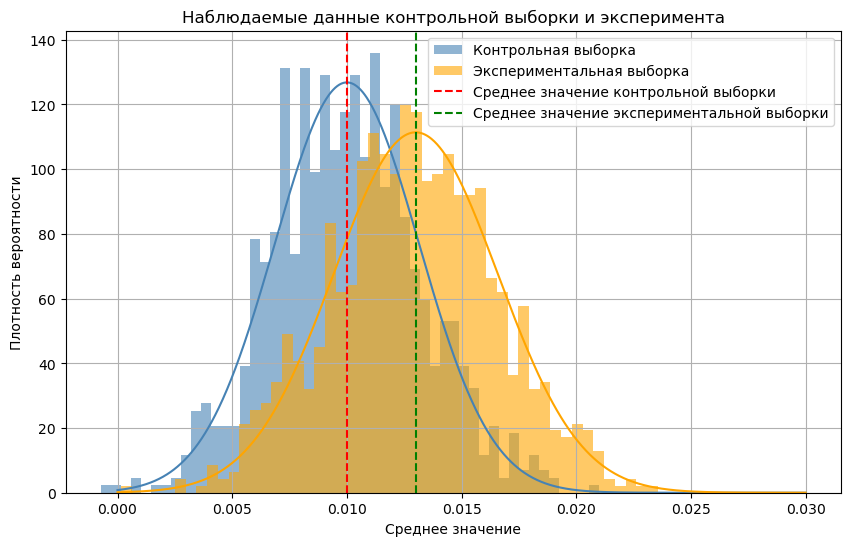

In [225]:
# Конверсии в процентах для двух групп
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE = 1000

# Параметры для распределения выборочных средних
sample_size = SIZE
num_samples = SIZE

# Вычисление параметров нормального распределения выборочных средних
std_of_control_means = np.sqrt(conversion_rate_control*(1-conversion_rate_control)/sample_size)
std_of_experiment_means = np.sqrt(conversion_rate_experiment*(1-conversion_rate_experiment)/sample_size)

sample_control = stats.norm.rvs(loc=conversion_rate_control, scale=std_of_control_means, size=num_samples)
sample_experiment = stats.norm.rvs(loc=conversion_rate_experiment, scale=std_of_experiment_means, size=num_samples)

# Генерация значений для оси X
x = np.linspace(0, 
                0.03, 
                num_samples)

# Вычисление плотности вероятности для нормального распределения
pdf_control = stats.norm.pdf(x, conversion_rate_control, std_of_control_means)
pdf_experiment = stats.norm.pdf(x, conversion_rate_experiment, std_of_experiment_means)

# Построение графика плотности распределения выборочных средних
plt.figure(figsize=(10, 6))
plt.hist(sample_control, bins=50, density=True, alpha=0.6, color='steelblue', label='Контрольная выборка')
plt.hist(sample_experiment, bins=50, density=True, alpha=0.6, color='orange', label='Экспериментальная выборка')
plt.plot(x, pdf_control, color='steelblue')
plt.plot(x, pdf_experiment, color='orange')
plt.title('Наблюдаемые данные контрольной выборки и эксперимента')
plt.xlabel('Среднее значение')
plt.ylabel('Плотность вероятности')
plt.axvline(x=conversion_rate_control, color='red', linestyle='--', label='Среднее значение контрольной выборки')
plt.axvline(x=conversion_rate_experiment, color='green', linestyle='--', label='Среднее значение экспериментальной выборки')
plt.legend()
plt.grid(True)
# plt.savefig('../Presentation/exp_distribution.png')
plt.show()

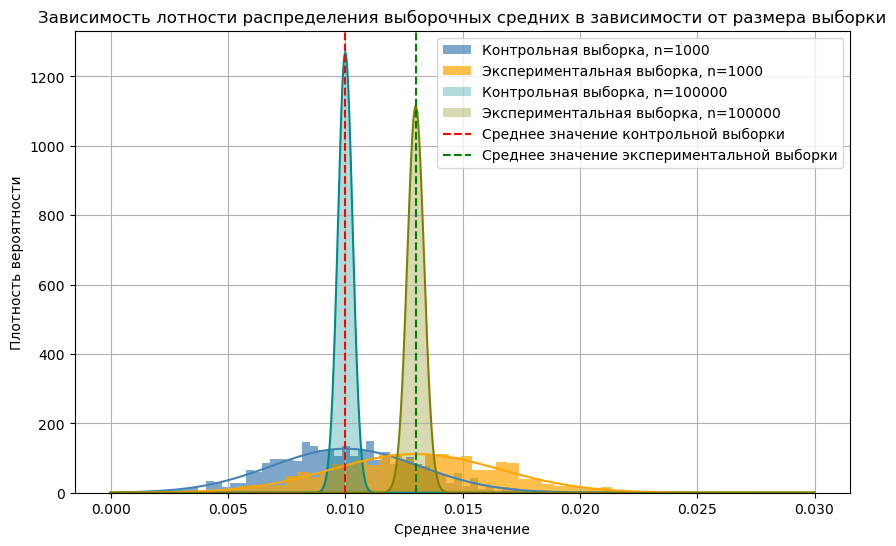

In [223]:
# Конверсии в процентах для двух групп
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE_1 = 1000
SIZE_2 = 100000

# Параметры для распределения выборочных средних
sample_size_1 = SIZE_1
num_samples_1 = SIZE_1
sample_size_2 = SIZE_2
num_samples_2 = SIZE_2

# Вычисление параметров нормального распределения выборочных средних
std_of_control_means_1 = np.sqrt(conversion_rate_control*(1-conversion_rate_control)/sample_size_1)
std_of_experiment_means_1 = np.sqrt(conversion_rate_experiment*(1-conversion_rate_experiment)/sample_size_1)
std_of_control_means_2 = np.sqrt(conversion_rate_control*(1-conversion_rate_control)/sample_size_2)
std_of_experiment_means_2 = np.sqrt(conversion_rate_experiment*(1-conversion_rate_experiment)/sample_size_2)

sample_control_1 = stats.norm.rvs(loc=conversion_rate_control, scale=std_of_control_means_1, size=num_samples_1)
sample_experiment_1 = stats.norm.rvs(loc=conversion_rate_experiment, scale=std_of_experiment_means_1, size=num_samples_1)
sample_control_2 = stats.norm.rvs(loc=conversion_rate_control, scale=std_of_control_means_2, size=num_samples_2)
sample_experiment_2 = stats.norm.rvs(loc=conversion_rate_experiment, scale=std_of_experiment_means_2, size=num_samples_2)

# Генерация значений для оси X
x = np.linspace(0, 0.03, sample_size_2)

# Вычисление плотности вероятности для нормального распределения
pdf_control_1 = stats.norm.pdf(x, conversion_rate_control, std_of_control_means_1)
pdf_experiment_1 = stats.norm.pdf(x, conversion_rate_experiment, std_of_experiment_means_1)
pdf_control_2 = stats.norm.pdf(x, conversion_rate_control, std_of_control_means_2)
pdf_experiment_2 = stats.norm.pdf(x, conversion_rate_experiment, std_of_experiment_means_2)

# Построение графика плотности распределения выборочных средних
plt.figure(figsize=(10, 6))
plt.hist(sample_control_1, bins=50, density=True, alpha=0.7, color='steelblue', label=f'Контрольная выборка, n={SIZE_1}')
plt.hist(sample_experiment_1, bins=50, density=True, alpha=0.7, color='orange', label=f'Экспериментальная выборка, n={SIZE_1}')
plt.hist(sample_control_2, bins=50, density=True, alpha=0.3, color='darkcyan', label=f'Контрольная выборка, n={SIZE_2}')
plt.hist(sample_experiment_2, bins=50, density=True, alpha=0.3, color='olive', label=f'Экспериментальная выборка, n={SIZE_2}')
plt.plot(x, pdf_control_1, color='steelblue')
plt.plot(x, pdf_control_2, color='darkcyan')
plt.plot(x, pdf_experiment_1, color='orange')
plt.plot(x, pdf_experiment_2, color='olive')
plt.title('Зависимость лотности распределения выборочных средних в зависимости от размера выборки')
plt.xlabel('Среднее значение')
plt.ylabel('Плотность вероятности')
plt.axvline(x=conversion_rate_control, color='red', linestyle='--', label='Среднее значение контрольной выборки')
plt.axvline(x=conversion_rate_experiment, color='green', linestyle='--', label='Среднее значение экспериментальной выборки')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

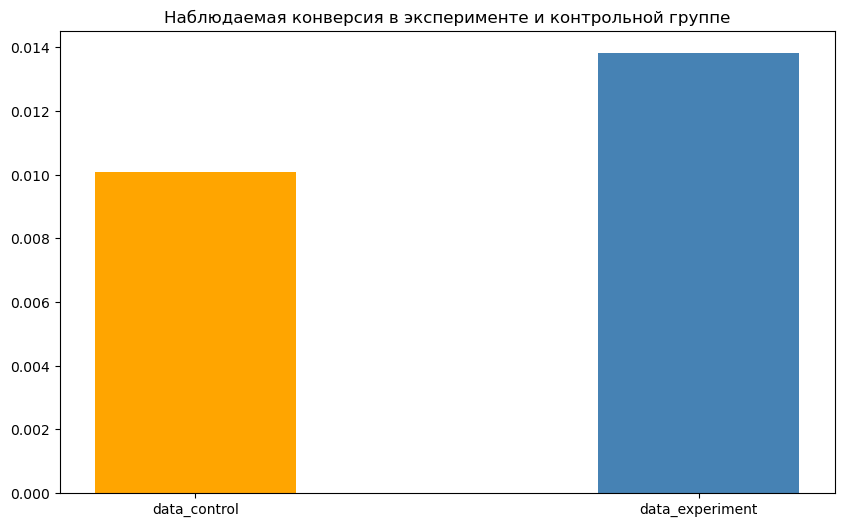

In [405]:
# Конверсии в процентах для двух групп
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE = 100000

# Создаем массивы для групп, где 1 представляет конверсию, а 0 - неконверсию
data_control = np.random.binomial(1, conversion_rate_control, size=SIZE).mean()
data_experiment = np.random.binomial(1, conversion_rate_experiment, size=SIZE).mean()
if data_control > data_experiment:
    colors = ['steelblue', 'orange']
else:
    colors = ['orange', 'steelblue']

plt.figure(figsize=(10, 6))
plt.bar(['data_control', 'data_experiment'], [data_control, data_experiment], color=colors, width=0.4)
plt.title('Наблюдаемая конверсия в эксперименте и контрольной группе')
plt.show()

### А какой размен выборки необходим, чтобы зафиксировать различия такой величины?

Мы хотим оценить какой минимальный размер выборки нам нужен, что бы выловить наши различия, т.е что бы они стали статистически значимыми.

$$n = \Bigg( \frac{Z_{\alpha / 2} \sqrt{2\cdot BCR(1-BCR)} + Z_{\beta} \sqrt{BCR \cdot (1-BCR)+ BCR'(1-BCR')}}{\delta} \Bigg)^2$$

$Z_{\alpha / 2}$ - критическое значение, соответствующее искомому уровню значимости $\alpha / 2$. Берется $\alpha / 2$ потому, что мы рассматриваем двусторонний тест. Значение $\alpha$ определяет уровень допустимости ошибки первого рода. Как правило $\alpha$ берется 0.05 для обычных исследовний и 0.01 для случая медицинских исследований или иных, где ошибка первого рода (отвергнута верная нулевая гипотеза) является критически важной.

$Z_\beta$ - критическое значение, соответствующее заданному уровню статистической мощности. Значение $\beta$ определяет вероятность ошибки второго рода (принята неверная нулевая гипотеза). Как правило $\beta$ устанавливается на уровне 0.8 или 0.9.

$\sigma$ - стандартное отклонение

$\delta$ - размер эффекта, который необходимо выловить

$BCR$ - базовый показатель конверсии

$BCR'$ - показатель конверсии после изменений $= BCR + \delta$

In [135]:
p_experiment = 0.013
p_control = 0.01
effect_size = p_experiment - p_control
confidence_level = 0.95
power = 0.8

z_alpha = stats.norm.ppf(1 - (1 - confidence_level) / 2)
print(f'Z_alpha / 2: {np.round(z_alpha, 2)}')
z_beta = abs(stats.norm.ppf(1 - power))
print(f'Z_beta: {np.round(z_beta, 2)}')

sample_size = ((z_alpha*np.sqrt(2*p_control*(1-p_control)) + z_beta*np.sqrt(p_control*(1-p_control)+p_experiment*(1-p_experiment)))/effect_size)**2

# Округляем до целого значения
sample_size = int(sample_size) + 1

print(f"Минимальный размер выборки для каждой группы: {sample_size}")

Z_alpha / 2: 1.96
Z_beta: 0.84
Минимальный размер выборки для каждой группы: 18017


## Рассчитаем эффект с помощью статистического пакета

In [433]:
from statsmodels.stats.power import tt_ind_solve_power

In [235]:
# Конверсии в процентах для двух групп
conversion_rate_experiment = 0.013  # Группа эксперимента
conversion_rate_control = 0.01  # Группа контроля
SIZE = 1000

# Параметры для распределения выборочных средних
sample_size = SIZE

# Вычисление параметров нормального распределения выборочных средних
std_of_experiment_means = np.sqrt(conversion_rate_experiment*(1-conversion_rate_experiment)/sample_size)
std_of_control_means = np.sqrt(conversion_rate_control*(1-conversion_rate_control)/sample_size)

# Размер эффекта для использования в пакете statsmodels (разница между средними значениями, деленная на стандартное отклонение)
eff_size = 0.04

# Пример использования
sample_size = tt_ind_solve_power(effect_size=eff_size, alpha=0.05, power=0.8, alternative='two-sided')
print(f"Необходимое число наблюдений: {sample_size*2:.2f}")


Необходимое число наблюдений: 19624.07


### Распределение средних с новым размером выборки

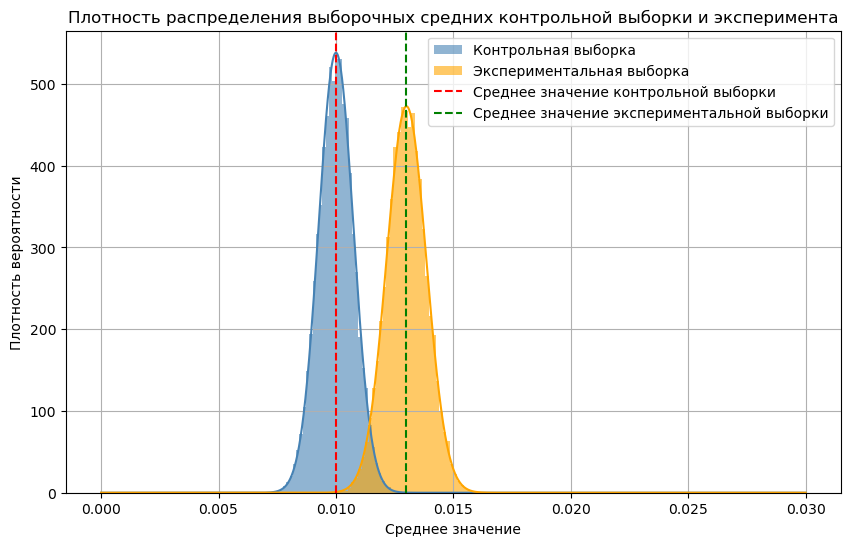

In [139]:
# Конверсии в процентах для двух групп
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE = 18000

# Параметры для распределения выборочных средних
sample_size = SIZE
num_samples = SIZE

# Вычисление параметров нормального распределения выборочных средних
std_of_control_means = np.sqrt(conversion_rate_control*(1-conversion_rate_control)/sample_size)
std_of_experiment_means = np.sqrt(conversion_rate_experiment*(1-conversion_rate_experiment)/sample_size)

sample_control = stats.norm.rvs(loc=conversion_rate_control, scale=std_of_control_means, size=num_samples)
sample_experiment = stats.norm.rvs(loc=conversion_rate_experiment, scale=std_of_experiment_means, size=num_samples)

# Генерация значений для оси X
x = np.linspace(0, 0.03, 
                num_samples)

# Вычисление плотности вероятности для нормального распределения
pdf_control = stats.norm.pdf(x, conversion_rate_control, std_of_control_means)
pdf_experiment = stats.norm.pdf(x, conversion_rate_experiment, std_of_experiment_means)

# Построение графика плотности распределения выборочных средних
plt.figure(figsize=(10, 6))
plt.hist(sample_control, bins=50, density=True, alpha=0.6, color='steelblue', label='Контрольная выборка')
plt.hist(sample_experiment, bins=50, density=True, alpha=0.6, color='orange', label='Экспериментальная выборка')
plt.plot(x, pdf_control, color='steelblue')
plt.plot(x, pdf_experiment, color='orange')
plt.title('Плотность распределения выборочных средних контрольной выборки и эксперимента')
plt.xlabel('Среднее значение')
plt.ylabel('Плотность вероятности')
plt.axvline(x=conversion_rate_control, color='red', linestyle='--', label='Среднее значение контрольной выборки')
plt.axvline(x=conversion_rate_experiment, color='green', linestyle='--', label='Среднее значение экспериментальной выборки')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Доверительный интервал

### Классический метод Уолда
Скорректированная вероятность:
$$
\hat{p}=\frac{p+\frac{z^2}{2n}}{1+\frac{z^2}{n}}
$$
Стандартная ошибка:
$$
SE=\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}
$$

Доверительный интервал Уолда:
$$
CI = \hat{p} \pm z\cdot SE
$$

#### Ограничения метода Уолда:
- Малые выборки: Метод Уолда может давать неточные результаты для малых выборок, так как предполагает нормальное распределение.
- Экстремальные вероятности: Когда вероятности близки к 0 или 1, доверительные интервалы могут выходить за допустимые пределы (например, отрицательные значения или значения больше 1), что не имеет смысла для вероятностей.
- Асимметрия: Метод Уолда не учитывает асимметрию распределения вероятностей, что может приводить к несимметричным и неточным интервалам.

### Метод Уилсона
Его нужно применять в случае маленьких выборок 

$$
E = \frac{z}{1+\frac{z^2}{n}}\sqrt{\frac{\hat{p}(1-\hat{p})}{n}+\frac{z^2}{4n^2}}
$$
Доверительный интервал Уилсона:
$$
CI = \hat{p} \pm E
$$
Этот метод особенно полезен, когда выборка мала или вероятности близки к крайним значениям (0, 1), так как он обеспечивает более точные и надежные интервалы по сравнению с традиционным методом Уолда.

In [140]:
conversion_experiment = 0.013  # Конверсия в эксперименте
n_experiment = 18000  # Общее количество наблюдений в эксперименте

# Вычисляем стандартную ошибку для доли (конверсии)
std_err = np.sqrt(conversion_experiment * (1 - conversion_experiment) / n_experiment)

# Определение уровня доверия
confidence_level = 0.95

# Рассчитываем критическое значение Z-статистики для доверительного интервала
z_critical = stats.norm.ppf(1 - (1 - confidence_level) / 2)

# Рассчитываем доверительный интервал Уолда
lower_bound = (conversion_experiment + z_critical**2 / (2 * n_experiment) - z_critical * std_err) / (1 + z_critical**2 / n_experiment)
upper_bound = (conversion_experiment + z_critical**2 / (2 * n_experiment) + z_critical * std_err) / (1 + z_critical**2 / n_experiment)

print(f"Доверительный интервал: [{lower_bound:.4f}, {upper_bound:.4f}]")
print(f'Ожидаемая конверсия {lower_bound:.4f} <- {conversion_experiment} -> {upper_bound:.4f}')

Доверительный интервал: [0.0114, 0.0148]
Ожидаемая конверсия 0.0114 <- 0.013 -> 0.0148


## Дополнительная литература
- [Как выбрать правильный стат тест для разных метрик](https://habr.com/ru/companies/otus/articles/805961/)
- [Размер выборки для A/B теста](https://habr.com/ru/articles/796341/)


## Изменение мощности теста

In [199]:
# предположим, это истинные эффекты лекарств
true_effect_control = 0.05
true_effect_treatment = 0.056

# размеры выборок на каждом этапе
sample_sizes = range(1000, 10001, 1000)

# смулируем данные
np.random.seed(42)
control_group = np.random.normal(true_effect_control, 0.1, sample_sizes[-1])
treatment_group = np.random.normal(true_effect_treatment, 0.1, sample_sizes[-1])

for size in sample_sizes:
    current_control = control_group[:size]
    current_treatment = treatment_group[:size]
    
    # выполним двухвыборочный t-тест
    t_stat, p_value = stats.ttest_ind(current_treatment, current_control)
    
    # print(f"Sample size: {size}, P-value: {p_value:.4f}")
    
    if p_value < alpha:
        print(f"{bcolors.OKGREEN}Отвергаем нулевую гипотезу: Sample size: {size}, P-value: {p_value:.2f} < {alpha}{bcolors.ENDC}")
    else:
        print(f"{bcolors.FAIL}Не отвергаем нулевую гипотезу: Sample size: {size}, P-value: {p_value:.2f} > {alpha}{bcolors.ENDC}")

Не отвергаем нулевую гипотезу: Sample size: 1000, P-value: 0.99 > 0.05
Не отвергаем нулевую гипотезу: Sample size: 2000, P-value: 0.73 > 0.05
Не отвергаем нулевую гипотезу: Sample size: 3000, P-value: 0.59 > 0.05
Отвергаем нулевую гипотезу: Sample size: 4000, P-value: 0.04 < 0.05
Отвергаем нулевую гипотезу: Sample size: 5000, P-value: 0.00 < 0.05
Отвергаем нулевую гипотезу: Sample size: 6000, P-value: 0.00 < 0.05
Отвергаем нулевую гипотезу: Sample size: 7000, P-value: 0.00 < 0.05
Отвергаем нулевую гипотезу: Sample size: 8000, P-value: 0.00 < 0.05
Отвергаем нулевую гипотезу: Sample size: 9000, P-value: 0.00 < 0.05
Отвергаем нулевую гипотезу: Sample size: 10000, P-value: 0.00 < 0.05
